# **Class Activation Mapping (CAM) in PyTorch**


---
The code here allows you to import a particular set of weights into a ResNet18 model that has been customized for ternary classification (The fc layer takes in 512 features and outputs 3 features), import any image you want to perform a prediction for and automatically preprocess the image so that we can generate heatmaps from it.

The output will be the heatmap juxtaposed over the original image to show us which parts of the image were most instrumental in deriving the classification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn
from torch import topk
import torchvision
import numpy as np
import skimage.transform
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd 
import matplotlib.pyplot as plt
from torchvision import datasets
import tensorflow

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Define a class that allows us to hook to any model or any part of a model
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

# Define a method to get the Class Activation Mapping
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

# Define a transform for normalization
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

#Define a transform for resizing
display_transform = transforms.Compose([
   transforms.Resize((224,224))
])

# Define a composition of transforms for resizing to 224x224 and normalizing
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.Grayscale(3),
   transforms.ToTensor(),
   normalize
])

In [ ]:
# Initialize our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft.load_state_dict(torch.load('/content/drive/My Drive/resnet_covid_weights.pickle'))
model_ft.cuda()
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
data_dir = '/content/drive/My Drive/10_all_data_foldered/images/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = ImageFolderWithPaths(datadir,       
                    transform=train_transforms)
    test_data = ImageFolderWithPaths(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.seed(50)
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['covid', 'normal', 'viral_pneumonia']


In [ ]:
#df1 = df = pd.DataFrame({"FILE PATH":[], "LOSS":[]}) 
#df1.to_csv(r'/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/loss_updated.csv', index = False)
df1 = pd.read_csv('/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/loss_updated.csv')
#print(df1)

In [ ]:
for inputs, labels, paths in testloader:
        if paths not in df1.values:
          inputs, labels = inputs.to(device), labels.to(device)
          logps = model_ft(inputs)
          loss = criterion(logps, labels)
          loss_val = torch.Tensor.item(loss)
          data = { "FILE PATH": [], "LOSS":[]}
          data['FILE PATH'].append(paths)
          data['LOSS'].append(loss_val)
          df2 = pd.DataFrame(data) 
          df1 = df1.append(df2)

In [ ]:
#print(df1)
#print(len(testloader))
#df1.to_csv(r'/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/loss_updated.csv', index = False)

In [ ]:
sort_by_loss = df1.sort_values('LOSS',ascending=False)
print(sort_by_loss.head(n=5))
for i in range(5):
  print(sort_by_loss.iloc[i]['FILE PATH'])


                                             FILE PATH      LOSS
209  ('/content/drive/My Drive/Kaggle/COVID-19 Radi...  8.554082
38   ('/content/drive/My Drive/Kaggle/COVID-19 Radi...  8.412813
424  ('/content/drive/My Drive/Kaggle/COVID-19 Radi...  8.401974
175  ('/content/drive/My Drive/Kaggle/COVID-19 Radi...  7.958136
123  ('/content/drive/My Drive/Kaggle/COVID-19 Radi...  7.821294
('/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/NORMAL/NORMAL (990).png',)
('/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/NORMAL/NORMAL (945).png',)
('/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/NORMAL/NORMAL (1270).png',)
('/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/NORMAL/NORMAL (770).png',)
('/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/NORMAL/NORMAL (854).png',)


tensor([[ 6.6380, -5.7787, -1.8419]], device='cuda:0', grad_fn=<AddmmBackward>)


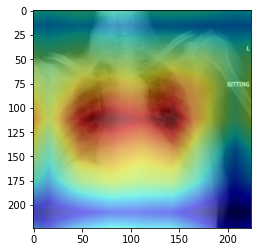

In [ ]:
# Use this cell block to fetch an image and generate the heatmap

# We use SaveFeatures function to attach a hook to the last sequential layer
final_layer = model_ft._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

# Showing the original image
image = Image.open("/content/drive/My Drive/Kaggle/COVID-19 Radiography Database/COVID-19/COVID-19 (26).png")

# Resize and normalize image
x = preprocess(image)

# Convert image into PyTorch variable
prediction_var = Variable((x.unsqueeze(0)).cuda(), requires_grad=True)

# Get a prediction from the model
prediction = model_ft(prediction_var)
print(prediction)

# Put through softmax layer to turn prediction into a series of probabilities for each class
pred_probabilities = F.softmax(prediction, dim = 0).data.squeeze()
activated_features.remove()

# Generates and shows the heatmap
weight_softmax_params = list(model_ft._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

# Overlays the heatmap on top of the original image
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], x.shape[1:3]), alpha=0.5, cmap='jet');

**What we are looking out for**
---
Presence of bilateral abnormalities, **ground-glass opacity** (hazy opacity that does not obscure the underlying bronchial structures or pulmonary vessels) and interstitial abnormalities, **their progression and extent over duration of disease onset help to determine severity of patient's condition**.

Two assessment metrics used include **geographic extent** and **opacity extent**. 

**Geographic extent** refers to the extent of lung involvement by ground glass opacity, each lung is scored separately and then added to produce a total score between 0-8 (0-4 for each lung). **Opacity extent** is calculated similarly.

Generally, there is a strong relationship between geographic extent of lung involvement by ground glass opacity and degree of lung opacity. Problem is in early stages, the signs of opacity can be quite hard to notice.